In [12]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


import tensorflow_addons as tfa

In [13]:
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

In [14]:
data_path = '/home/shellygoel2324/data_merged.csv'
#labels_path = '/home/shellygoel2324/processedLabels.csv'

In [15]:
def load_pose_landmarks(csv_path):
    """Loads a CSV created by MoveNetPreprocessor.
    Returns:
        X: Detected landmark coordinates and scores of shape (N, 17 * 3)
        y: Ground truth labels of shape (N, label_count)
        classes: The list of all class names found in the dataset
        dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
        truth labels (y) to use later to train a pose classification model.
    """

    # Load the CSV file
    dataframe = pd.read_csv(csv_path)
    
    labels = dataframe["label"] - 1#pd.read_csv(labels_path, header=None)
    
    print(labels.unique())
    df_to_process = dataframe.copy()

    # Drop the file_name columns as you don't need it during training.
    df_to_process.drop(columns=['file_name'], inplace=True)

    # Extract the list of class names
    df_to_process.pop('class_name')
    df_to_process.pop('class_no')
    df_to_process.pop('label')

    # Extract the labels
    y = labels
    classes = range(6)

    # Convert the input features and labels into the correct format for training.
    X = df_to_process.astype('float64')
    y = keras.utils.to_categorical(y)

    return X, y, classes, dataframe

In [16]:
# Load the train data
X, y, class_names, _ = load_pose_landmarks(data_path)

print(X.shape, y.shape)

# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)

# 80/10/10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1) # 0.25 x 0.8 = 0.2

#print(X_train.shape, X_val.shape, X_test.shape)

#60/20/20
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

[0. 3. 1. 2. 4. 5.]
(12056, 51) (12056, 6)


In [17]:
print("TRAIN DISTRIBUTION")

sample_dist = []
for i in range(0,6):
    
    num_i = 0
    for sample in y_train:
            if tf.argmax(sample) == i:
                num_i+=1
    dist = num_i/len(y_train)
    print(f"{i}: {dist}")
    sample_dist.append(dist)


print("\nTEST DISTRIBUTION")
for i in range(0,6):
    
    num_i = 0
    for sample in y_test:
            if tf.argmax(sample) == i:
                num_i+=1

    dist = num_i/len(y_test)
    print(f"{i}: {dist}")
    #sample_dist.append(dist)

TRAIN DISTRIBUTION


2022-05-31 01:07:08.400294: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-31 01:07:08.400353: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cs229-vm-vm): /proc/driver/nvidia/version does not exist
2022-05-31 01:07:08.402064: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0: 0.5412691829116549
1: 0.25964330153463294
2: 0.11406055578598093
3: 0.047698050601410205
4: 0.02789299046038988
5: 0.009435918705931148

TEST DISTRIBUTION
0: 0.5655058043117744
1: 0.2462686567164179
2: 0.11525704809286899
3: 0.0472636815920398
4: 0.02155887230514096
5: 0.0041459369817578775


In [18]:
sample_dist = sample_dist/np.linalg.norm(sample_dist)
weight_balanced= [1/s for s in sample_dist]

print(sample_dist)
print(weight_balanced)
#weight_balanced = weight_balanced/np.linalg.norm(weight_balanced)
#print(weight_balanced)
#print(np.sum(weight_balanced))

[0.88208077 0.4231284  0.18587909 0.07773126 0.04545589 0.01537727]
[1.1336830354812486, 2.3633488199728907, 5.379841313829198, 12.86483792437417, 21.99935109744282, 65.03104884848482]


In [19]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
    """Calculates the center point of the two given landmarks."""
    
    left = tf.gather(landmarks, left_bodypart.value, axis=1)
    right = tf.gather(landmarks, right_bodypart.value, axis=1)
    center = left * 0.5 + right * 0.5
    return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
    """Calculates pose size.

        It is the maximum of two values:
        * Torso size multiplied by `torso_size_multiplier`
        * Maximum distance from pose center to any pose landmark
    """
    # Hips center
    hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

    # Shoulders center
    shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

    # Torso size as the minimum body size
    torso_size = tf.linalg.norm(shoulders_center - hips_center)

    # Pose center
    pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
    pose_center_new = tf.expand_dims(pose_center_new, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to
    # perform substraction
    pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

    # Dist to pose center
    d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
    # Max dist to pose center
    max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

    # Normalize scale
    pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

    return pose_size


def normalize_pose_landmarks(landmarks):
    """Normalizes the landmarks translation by moving the pose center to (0,0) and
        scaling it to a constant pose size.
    """
    # Move landmarks so that the pose center becomes (0,0)
    pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
    pose_center = tf.expand_dims(pose_center, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to perform
    # substraction
    pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
    landmarks = landmarks - pose_center

    # Scale the landmarks to a constant pose size
    pose_size = get_pose_size(landmarks)
    landmarks /= pose_size

    return landmarks


def landmarks_to_embedding(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Normalize landmarks 2D
    landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

    # Flatten the normalized landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks)

    return embedding

def no_normalization(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    landmarks = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Flatten the landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks[:, :, :2])

    return embedding

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """Plots the confusion matrix."""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


## Normalize everything

In [21]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 17, 3)        0           ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 17, 2)       0           ['reshape[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.compat.v1.gather (TFOpLambd  (None, 2)           0           ['tf.__operators__.getitem[0]

 )                                                                                                
                                                                                                  
 tf.broadcast_to_1 (TFOpLambda)  (None, 17, 2)       0           ['tf.expand_dims_1[0][0]',       
                                                                  'tf.compat.v1.floor_div_1[0][0]'
                                                                 ]                                
                                                                                                  
 tf.__operators__.add_2 (TFOpLa  (None, 2)           0           ['tf.math.multiply_4[0][0]',     
 mbda)                                                            'tf.math.multiply_5[0][0]']     
                                                                                                  
 tf.__operators__.add_1 (TFOpLa  (None, 2)           0           ['tf.math.multiply_2[0][0]',     
 mbda)    

In [22]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [23]:
model.compile(
    optimizer='adam',
    loss=tfa.losses.SigmoidFocalCrossEntropy(),#'categorical_crossentropy',
    metrics=METRICS
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
#checkpoint_path = "weights.best.hdf5"

checkpoint_path = "weights.best.onlyfocalloss"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              patience=20)

# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
586/603 [============================>.] - ETA: 0s - loss: 0.1551 - tp: 3236.0000 - fp: 216.0000 - tn: 46664.0000 - fn: 6140.0000 - accuracy: 0.8870 - precision: 0.9374 - recall: 0.3451 - auc: 0.9261 - prc: 0.7830
Epoch 1: val_loss improved from inf to 0.09918, saving model to weights.best.onlyfocalloss


2022-05-31 01:07:20.850928: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
603/603 [==============================] - 7s 7ms/step - loss: 0.1538 - tp: 3374.0000 - fp: 225.0000 - tn: 47995.0000 - fn: 6270.0000 - accuracy: 0.8878 - precision: 0.9375 - recall: 0.3499 - auc: 0.9274 - prc: 0.7866 - val_loss: 0.0992 - val_tp: 671.0000 - val_fp: 36.0000 - val_tn: 5994.0000 - val_fn: 535.0000 - val_accuracy: 0.9211 - val_precision: 0.9491 - val_recall: 0.5564 - val_auc: 0.9699 - val_prc: 0.8992
Epoch 2/200
593/603 [============================>.] - ETA: 0s - loss: 0.1119 - tp: 5020.0000 - fp: 285.0000 - tn: 47155.0000 - fn: 4468.0000 - accuracy: 0.9165 - precision: 0.9463 - recall: 0.5291 - auc: 0.9628 - prc: 0.8792
Epoch 2: val_loss improved from 0.09918 to 0.08529, saving model to weights.best.onlyfocalloss
INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
603/603 [==============================] - 3s 6ms/step - loss: 0.1116 - tp: 5115.0000 - fp: 287.0000 - tn: 47933.0000 - fn: 

Epoch 12/200
594/603 [============================>.] - ETA: 0s - loss: 0.0752 - tp: 6896.0000 - fp: 310.0000 - tn: 47210.0000 - fn: 2608.0000 - accuracy: 0.9488 - precision: 0.9570 - recall: 0.7256 - auc: 0.9832 - prc: 0.9407
Epoch 12: val_loss improved from 0.06311 to 0.06287, saving model to weights.best.onlyfocalloss
INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
603/603 [==============================] - 3s 5ms/step - loss: 0.0753 - tp: 6987.0000 - fp: 314.0000 - tn: 47906.0000 - fn: 2657.0000 - accuracy: 0.9487 - precision: 0.9570 - recall: 0.7245 - auc: 0.9831 - prc: 0.9406 - val_loss: 0.0629 - val_tp: 929.0000 - val_fp: 43.0000 - val_tn: 5987.0000 - val_fn: 277.0000 - val_accuracy: 0.9558 - val_precision: 0.9558 - val_recall: 0.7703 - val_auc: 0.9884 - val_prc: 0.9539
Epoch 13/200
595/603 [============================>.] - ETA: 0s - loss: 0.0741 - tp: 6925.0000 - fp: 316.0000 - tn: 47284.0000 - fn: 2595.0000 - accuracy: 0.9490 - precision: 0.9564 - recall:

Epoch 23/200
599/603 [============================>.] - ETA: 0s - loss: 0.0665 - tp: 7227.0000 - fp: 297.0000 - tn: 47623.0000 - fn: 2357.0000 - accuracy: 0.9538 - precision: 0.9605 - recall: 0.7541 - auc: 0.9871 - prc: 0.9527
Epoch 23: val_loss improved from 0.05198 to 0.05175, saving model to weights.best.onlyfocalloss
INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
603/603 [==============================] - 3s 5ms/step - loss: 0.0667 - tp: 7270.0000 - fp: 299.0000 - tn: 47921.0000 - fn: 2374.0000 - accuracy: 0.9538 - precision: 0.9605 - recall: 0.7538 - auc: 0.9869 - prc: 0.9524 - val_loss: 0.0517 - val_tp: 963.0000 - val_fp: 33.0000 - val_tn: 5997.0000 - val_fn: 243.0000 - val_accuracy: 0.9619 - val_precision: 0.9669 - val_recall: 0.7985 - val_auc: 0.9922 - val_prc: 0.9699
Epoch 24/200
601/603 [============================>.] - ETA: 0s - loss: 0.0671 - tp: 7212.0000 - fp: 311.0000 - tn: 47769.0000 - fn: 2404.0000 - accuracy: 0.9529 - precision: 0.9587 - recall:

Epoch 34/200
586/603 [============================>.] - ETA: 0s - loss: 0.0639 - tp: 7234.0000 - fp: 277.0000 - tn: 46603.0000 - fn: 2142.0000 - accuracy: 0.9570 - precision: 0.9631 - recall: 0.7715 - auc: 0.9881 - prc: 0.9557
Epoch 34: val_loss did not improve from 0.04784
603/603 [==============================] - 2s 3ms/step - loss: 0.0645 - tp: 7430.0000 - fp: 290.0000 - tn: 47930.0000 - fn: 2214.0000 - accuracy: 0.9567 - precision: 0.9624 - recall: 0.7704 - auc: 0.9879 - prc: 0.9550 - val_loss: 0.0480 - val_tp: 968.0000 - val_fp: 29.0000 - val_tn: 6001.0000 - val_fn: 238.0000 - val_accuracy: 0.9631 - val_precision: 0.9709 - val_recall: 0.8027 - val_auc: 0.9936 - val_prc: 0.9738
Epoch 35/200
591/603 [============================>.] - ETA: 0s - loss: 0.0652 - tp: 7219.0000 - fp: 287.0000 - tn: 46993.0000 - fn: 2237.0000 - accuracy: 0.9555 - precision: 0.9618 - recall: 0.7634 - auc: 0.9876 - prc: 0.9547
Epoch 35: val_loss did not improve from 0.04784
603/603 [========================

603/603 [==============================] - 2s 3ms/step - loss: 0.0609 - tp: 7519.0000 - fp: 309.0000 - tn: 47911.0000 - fn: 2125.0000 - accuracy: 0.9579 - precision: 0.9605 - recall: 0.7797 - auc: 0.9893 - prc: 0.9594 - val_loss: 0.0472 - val_tp: 982.0000 - val_fp: 34.0000 - val_tn: 5996.0000 - val_fn: 224.0000 - val_accuracy: 0.9643 - val_precision: 0.9665 - val_recall: 0.8143 - val_auc: 0.9937 - val_prc: 0.9738
Epoch 46/200
588/603 [============================>.] - ETA: 0s - loss: 0.0613 - tp: 7316.0000 - fp: 287.0000 - tn: 46753.0000 - fn: 2092.0000 - accuracy: 0.9579 - precision: 0.9623 - recall: 0.7776 - auc: 0.9892 - prc: 0.9591
Epoch 46: val_loss improved from 0.04619 to 0.04555, saving model to weights.best.onlyfocalloss
INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
603/603 [==============================] - 3s 6ms/step - loss: 0.0615 - tp: 7500.0000 - fp: 295.0000 - tn: 47925.0000 - fn: 2144.0000 - accuracy: 0.9578 - precision: 0.9622 - recall: 0.7777 -

Epoch 57/200
595/603 [============================>.] - ETA: 0s - loss: 0.0587 - tp: 7488.0000 - fp: 271.0000 - tn: 47329.0000 - fn: 2032.0000 - accuracy: 0.9597 - precision: 0.9651 - recall: 0.7866 - auc: 0.9900 - prc: 0.9630
Epoch 57: val_loss did not improve from 0.04475
603/603 [==============================] - 2s 3ms/step - loss: 0.0587 - tp: 7590.0000 - fp: 274.0000 - tn: 47946.0000 - fn: 2054.0000 - accuracy: 0.9598 - precision: 0.9652 - recall: 0.7870 - auc: 0.9900 - prc: 0.9630 - val_loss: 0.0451 - val_tp: 996.0000 - val_fp: 27.0000 - val_tn: 6003.0000 - val_fn: 210.0000 - val_accuracy: 0.9672 - val_precision: 0.9736 - val_recall: 0.8259 - val_auc: 0.9942 - val_prc: 0.9762
Epoch 58/200
599/603 [============================>.] - ETA: 0s - loss: 0.0587 - tp: 7536.0000 - fp: 269.0000 - tn: 47651.0000 - fn: 2048.0000 - accuracy: 0.9597 - precision: 0.9655 - recall: 0.7863 - auc: 0.9901 - prc: 0.9621
Epoch 58: val_loss did not improve from 0.04475
603/603 [========================

Epoch 69/200
593/603 [============================>.] - ETA: 0s - loss: 0.0571 - tp: 7487.0000 - fp: 263.0000 - tn: 47177.0000 - fn: 2001.0000 - accuracy: 0.9602 - precision: 0.9661 - recall: 0.7891 - auc: 0.9907 - prc: 0.9640
Epoch 69: val_loss did not improve from 0.04410
603/603 [==============================] - 2s 3ms/step - loss: 0.0570 - tp: 7613.0000 - fp: 267.0000 - tn: 47953.0000 - fn: 2031.0000 - accuracy: 0.9603 - precision: 0.9661 - recall: 0.7894 - auc: 0.9908 - prc: 0.9641 - val_loss: 0.0451 - val_tp: 1005.0000 - val_fp: 33.0000 - val_tn: 5997.0000 - val_fn: 201.0000 - val_accuracy: 0.9677 - val_precision: 0.9682 - val_recall: 0.8333 - val_auc: 0.9943 - val_prc: 0.9763
Epoch 70/200
590/603 [============================>.] - ETA: 0s - loss: 0.0575 - tp: 7449.0000 - fp: 294.0000 - tn: 46906.0000 - fn: 1991.0000 - accuracy: 0.9597 - precision: 0.9620 - recall: 0.7891 - auc: 0.9904 - prc: 0.9636
Epoch 70: val_loss did not improve from 0.04410
603/603 [=======================

Epoch 81/200
587/603 [============================>.] - ETA: 0s - loss: 0.0557 - tp: 7507.0000 - fp: 273.0000 - tn: 46687.0000 - fn: 1885.0000 - accuracy: 0.9617 - precision: 0.9649 - recall: 0.7993 - auc: 0.9910 - prc: 0.9656
Epoch 81: val_loss did not improve from 0.04386
603/603 [==============================] - 2s 3ms/step - loss: 0.0559 - tp: 7705.0000 - fp: 286.0000 - tn: 47934.0000 - fn: 1939.0000 - accuracy: 0.9615 - precision: 0.9642 - recall: 0.7989 - auc: 0.9909 - prc: 0.9654 - val_loss: 0.0450 - val_tp: 986.0000 - val_fp: 24.0000 - val_tn: 6006.0000 - val_fn: 220.0000 - val_accuracy: 0.9663 - val_precision: 0.9762 - val_recall: 0.8176 - val_auc: 0.9943 - val_prc: 0.9767
Epoch 82/200
587/603 [============================>.] - ETA: 0s - loss: 0.0579 - tp: 7434.0000 - fp: 256.0000 - tn: 46704.0000 - fn: 1958.0000 - accuracy: 0.9607 - precision: 0.9667 - recall: 0.7915 - auc: 0.9904 - prc: 0.9640
Epoch 82: val_loss did not improve from 0.04386
603/603 [========================

Epoch 93/200
601/603 [============================>.] - ETA: 0s - loss: 0.0560 - tp: 7697.0000 - fp: 282.0000 - tn: 47798.0000 - fn: 1919.0000 - accuracy: 0.9619 - precision: 0.9647 - recall: 0.8004 - auc: 0.9911 - prc: 0.9656
Epoch 93: val_loss did not improve from 0.04386
603/603 [==============================] - 2s 3ms/step - loss: 0.0559 - tp: 7723.0000 - fp: 282.0000 - tn: 47938.0000 - fn: 1921.0000 - accuracy: 0.9619 - precision: 0.9648 - recall: 0.8008 - auc: 0.9912 - prc: 0.9657 - val_loss: 0.0443 - val_tp: 982.0000 - val_fp: 28.0000 - val_tn: 6002.0000 - val_fn: 224.0000 - val_accuracy: 0.9652 - val_precision: 0.9723 - val_recall: 0.8143 - val_auc: 0.9944 - val_prc: 0.9769
Epoch 94/200
582/603 [===========================>..] - ETA: 0s - loss: 0.0555 - tp: 7507.0000 - fp: 252.0000 - tn: 46308.0000 - fn: 1805.0000 - accuracy: 0.9632 - precision: 0.9675 - recall: 0.8062 - auc: 0.9910 - prc: 0.9662
Epoch 94: val_loss did not improve from 0.04386
603/603 [========================

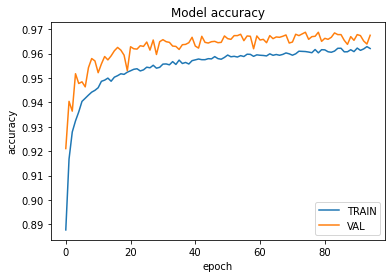

In [28]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

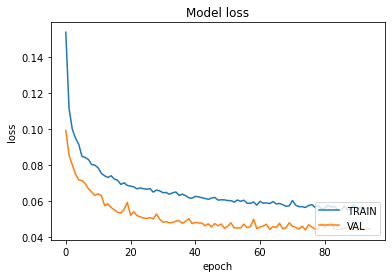

In [29]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [30]:
loss, tp, fp, tn, fn, accuracy, precision, recall, auc, prc = model.evaluate(X_test, y_test)

38/38 [==============================] - 0s 2ms/step - loss: 0.1221 - tp: 616.0000 - fp: 43.0000 - tn: 5987.0000 - fn: 590.0000 - accuracy: 0.9125 - precision: 0.9347 - recall: 0.5108 - auc: 0.9520 - prc: 0.8429


Normalized confusion matrix

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.72      0.84       682
           1       0.57      0.83      0.67       297
           2       0.58      0.81      0.67       139
           3       0.39      0.33      0.36        57
           4       0.57      0.46      0.51        26
           5       0.36      1.00      0.53         5

    accuracy                           0.74      1206
   macro avg       0.58      0.69      0.60      1206
weighted avg       0.80      0.74      0.75      1206



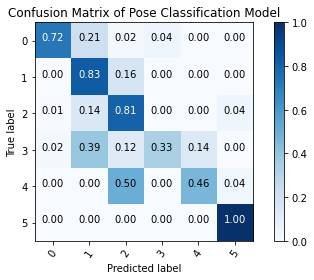

In [31]:
# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,normalize=True,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

In [ ]:
from sklearn import datasets
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

In [ ]:
#Classes 3, 4 Need to be weighted

